# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures
import re
import gzip 
import json
from glob import glob
from collections import Counter
import operator
from scipy.stats import ks_2samp

### Cleaning and EDA

Each github file (1 hour of a certain day) contains about `80,000` JSON objects, and if I simply call `pd.io.json.json_normalize()`, it will take about 1-2 minutes to finish normalizing the file. An optimized method to read a file is for each json object to only contain the 15 fields I'm interested in. Besides reducing down the number of columns from about 680, I will only focus on the times ranging from 4 to 6 pm. As such, each file will be successfully normalized in 10 seconds, a tenth of the original time. 

In [2]:
# flattens the json object to only contain the desired keys 
def flatten(d):
    
    # the 15 fields to look at 
    def get_keys():
        keys = ['type', 'actor.login', 'repo.name', 'created_at', 'org.login','payload.commits', 
            'payload.forkee.created_at', 'payload.pull_request.head.repo.forks_count',
            'payload.forkee.size','payload.pull_request.created_at', 'payload.pull_request.head.repo.has_issues', 
            'payload.pull_request.head.repo.watchers_count', 'payload.pull_request.base.repo.language', 
            'payload.pull_request.head.repo.license.key', 'payload.pull_request.head.repo.has_pages']

        return keys
    
    # goes down the nested dictionary to look for the value
    # if the key doesn't exist, return None
    def get_val(d, key_list):
            value = d.copy()
            for k in key_list:
                value = value.get(k, None)
                if value is None:
                    return None
            return value   
        
    values = {}
    keys = get_keys()
    for key in keys:
        key_list = key.split('.')
        values[key] = get_val(d, key_list)
        
    return values


The files are from October 20th to October 26th, 2019, the last full week of the month. 

In [3]:
# 21 github files to loop through 
directory = glob('/Users/kaihuang/Documents/github_data/2019-10-2[0-6]-1[6-8].json.gz')
github_data = pd.DataFrame()
for filepath in directory:
    # a list of dictionaries that will later be converted into a pandas DataFrame
    L = []
    # After unzipping the file, each line will be a json object
    for line in gzip.open(filepath):
        d = json.loads(line)
        L.append(flatten(d))
    processed_d = pd.DataFrame(L)
    # concatenates each file's DataFrame
    github_data = pd.concat([github_data, processed_d], sort = False)

For the rest of the project, I am only interested in the day of the week, so I'm going to convert the datetime to only its corresponding day of the week.

In [4]:
github_data_copy = github_data.copy().reset_index(drop = True)
github_data_copy['created_at'] = pd.to_datetime(github_data_copy['created_at']).dt.day_name()
github_data_copy['payload.pull_request.created_at'] = (
                        pd.to_datetime(github_data_copy['payload.pull_request.created_at'])
                        .dt.day_name())
github_data_copy['payload.forkee.created_at'] = (
                        pd.to_datetime(github_data_copy['payload.forkee.created_at'])
                        .dt.day_name())

We see that this dataframe has almost 2 million rows, with the 15 columns I chose out of the many. 

In [5]:
print(github_data_copy.shape)
github_data_copy.head()

(1974678, 15)


,actor.login,created_at,org.login,payload.commits,payload.forkee.created_at,payload.forkee.size,payload.pull_request.base.repo.language,payload.pull_request.created_at,payload.pull_request.head.repo.forks_count,payload.pull_request.head.repo.has_issues,payload.pull_request.head.repo.has_pages,payload.pull_request.head.repo.license.key,payload.pull_request.head.repo.watchers_count,repo.name,type
0,SergTanchenko,Sunday,None,[{'sha': '7cf4efd262220f35abbb9d1b0c05821a30bb...,NaN,NaN,None,NaN,NaN,None,None,None,NaN,SergTanchenko/spring-and-hibernate-for-beginners,PushEvent
1,dependabot-preview[bot],Sunday,None,None,NaN,NaN,JavaScript,Sunday,0.0,True,False,mit,0.0,fisker/power-cartesian-product,PullRequestEvent
2,beater13,Sunday,None,[{'sha': '574db2b2f24107c737e36360138bd9b9e6bd...,NaN,NaN,None,NaN,NaN,None,None,None,NaN,beater13/Univerity,PushEvent
3,dependabot-preview[bot],Sunday,dhis2,None,NaN,NaN,None,NaN,NaN,None,None,None,NaN,dhis2/app-runtime,IssueCommentEvent
4,greenkeeper[bot],Sunday,None,None,NaN,NaN,None,NaN,NaN,None,None,None,NaN,andnp/MaybeTyped,DeleteEvent


Let's first see the proportions of Github activities between 4-6pm across the week. Would people use Github more on Monday than on Saturday, for instance? Or the opposite?

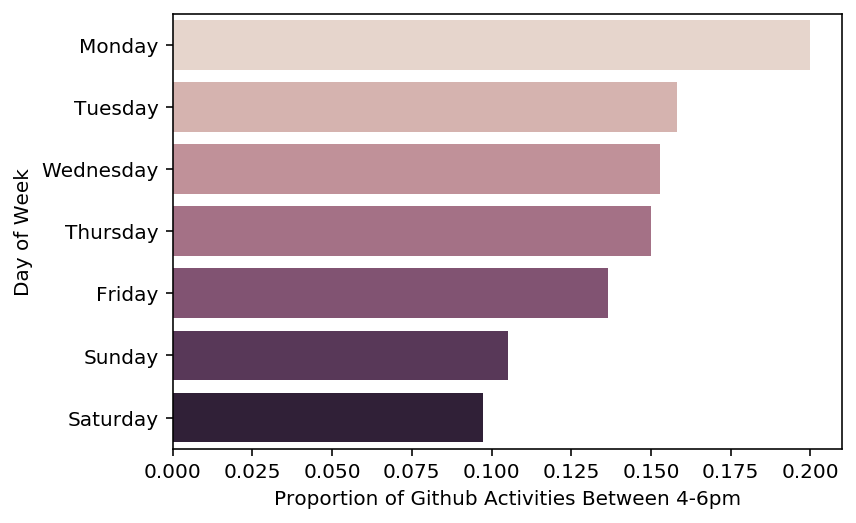

In [6]:
day_of_week_proportions = (github_data_copy['created_at']
                     .value_counts(normalize=True)
                     .reset_index()
                     .rename(columns = {'index': 'Day of Week', 
                                        'created_at':'Proportion of Github Activities Between 4-6pm'})
                     .sort_values('Proportion of Github Activities Between 4-6pm', ascending = False))
sns.barplot(x = 'Proportion of Github Activities Between 4-6pm', y = 'Day of Week', 
            palette= 'ch:.10', data = day_of_week_proportions)

Not surprisingly, there are more activities on the weekdays than on the weekend, as show in the following bar plot. However, it's interesting to note that Monday seems to stand out among the other weekdays.

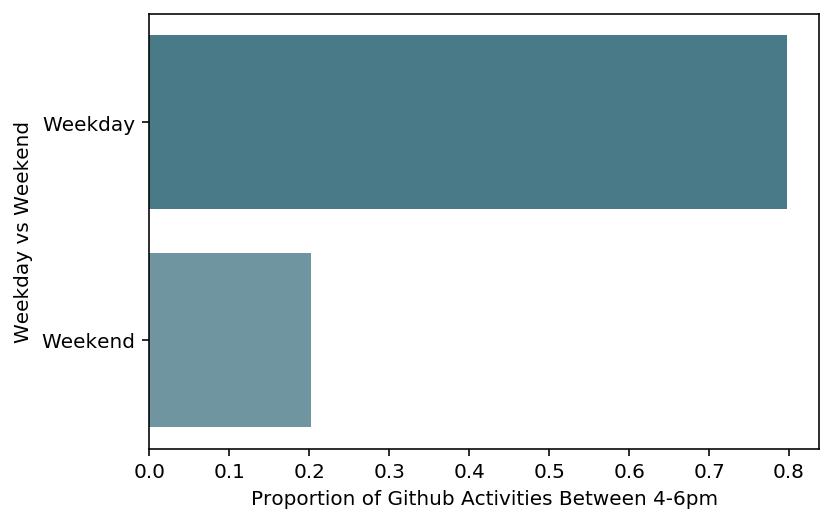

In [7]:
weekday_vs_weekend_proportions = (github_data_copy['created_at']
                     .replace({**dict.fromkeys(['Monday','Tuesday','Wednesday','Thursday', 'Friday'], 'Weekday'), 
                               **dict.fromkeys(['Saturday','Sunday'], 'Weekend')})
                     .value_counts(normalize=True)
                     .reset_index()
                     .rename(columns = {'index': 'Weekday vs Weekend', 
                                        'created_at':'Proportion of Github Activities Between 4-6pm'})
                     .sort_values('Proportion of Github Activities Between 4-6pm', ascending = False))
sns.barplot(x = 'Proportion of Github Activities Between 4-6pm', y = 'Weekday vs Weekend', 
            palette = sns.diverging_palette(217, 200, n=10) , data = weekday_vs_weekend_proportions)

### Commits 

Notice that the `payload.commit` column is a dictionary that needs separate parsing. Below, I have defined a function to extract the messages people write when they commit, and pass them into a new dataframe called `commits_info`.

In [8]:
def extract_commit_message(commits):
    if commits and 'message' in commits[0]:
        return commits[0]['message']

In [9]:
commits_info = (github_data_copy[['type', 'actor.login', 'repo.name', 'created_at', 'org.login']]
               .assign(commit_message = github_data_copy['payload.commits'].apply(extract_commit_message)))
print(commits_info.shape)
commits_info.head()

(1974678, 6)


,type,actor.login,repo.name,created_at,org.login,commit_message
0,PushEvent,SergTanchenko,SergTanchenko/spring-and-hibernate-for-beginners,Sunday,None,init fields with values from property files
1,PullRequestEvent,dependabot-preview[bot],fisker/power-cartesian-product,Sunday,None,None
2,PushEvent,beater13,beater13/Univerity,Sunday,None,Delete Student.class
3,IssueCommentEvent,dependabot-preview[bot],dhis2/app-runtime,Sunday,dhis2,None
4,DeleteEvent,greenkeeper[bot],andnp/MaybeTyped,Sunday,None,None


### Push Events

We know that all push events are commits, but not all commits are push events. Let's filter `commits_info` to only contain the push events.


In [10]:
push_events = commits_info[commits_info.type == 'PushEvent']
print(push_events.shape)
push_events.head()

(977458, 6)


,type,actor.login,repo.name,created_at,org.login,commit_message
0,PushEvent,SergTanchenko,SergTanchenko/spring-and-hibernate-for-beginners,Sunday,None,init fields with values from property files
2,PushEvent,beater13,beater13/Univerity,Sunday,None,Delete Student.class
5,PushEvent,Pyruvates,Pyruvates/Test,Sunday,None,first commit
6,PushEvent,renovate[bot],ericyip/react-priority-navigation,Sunday,None,Update dependency rollup to v1.25.1
7,PushEvent,jmoenig,jmoenig/Snap,Sunday,None,"generate stereo sounds\n\n if desired, by pas..."


Since we have a column of commit messages, let's find out which words are the most common!

In [11]:
def most_common_words(push_events):
    
    def remove_phrases(phrases, counter):
        for key in phrases:
            counter.pop(key, None)
                
    words = (push_events.commit_message
    .apply(lambda x: x.lower().split() if pd.notnull(x) else None))
    word_list = []
    miscellaneous = ['to', 'of', 'about', 'at', 'before', 'after', 'by', 'behind', 'during', 'for', 'via',
                     'from', 'on', 'in', 'over', 'under', 'and', 'with', 'a', '*', 'the', 'is', 'be', '-']
    for word in words:
        if word:
            word_list += word
    
    word_count = Counter(word_list)
    remove_phrases(miscellaneous, word_count)           
            
    return sorted(word_count.items(), key = operator.itemgetter(1), reverse = True)

words_count = most_common_words(push_events)

As expected, when people push their changes, they tend to say `update` or `add` a lot. Besides these two, there are other words such as `automatically` and `learn`.

In [12]:
words_count[:5]

[('update', 166898),
 ('add', 97902),
 ('up', 64485),
 ('automatically', 56588),
 ('learn', 56145)]

Let's investigate the message column further by first filtering out the null values. 

In [13]:
commits_message = push_events[push_events['commit_message'].notnull()]
print(commits_message.shape)
commits_message.head()

(942122, 6)


,type,actor.login,repo.name,created_at,org.login,commit_message
0,PushEvent,SergTanchenko,SergTanchenko/spring-and-hibernate-for-beginners,Sunday,None,init fields with values from property files
2,PushEvent,beater13,beater13/Univerity,Sunday,None,Delete Student.class
5,PushEvent,Pyruvates,Pyruvates/Test,Sunday,None,first commit
6,PushEvent,renovate[bot],ericyip/react-priority-navigation,Sunday,None,Update dependency rollup to v1.25.1
7,PushEvent,jmoenig,jmoenig/Snap,Sunday,None,"generate stereo sounds\n\n if desired, by pas..."


Let's see if whether the weekdays or the weekend include the word learn more in their commit message.

In [14]:
has_word_learn = (commits_message.replace({'created_at': {**dict.fromkeys(
         ['Monday','Tuesday','Wednesday','Thursday', 'Friday'],
        'Weekday'),
         **dict.fromkeys(['Saturday','Sunday'], 'Weekend')}})
         .assign(has_learn = commits_message['commit_message']
         .apply(lambda x: 'learn' in x.lower())))
has_word_learn.head()

,type,actor.login,repo.name,created_at,org.login,commit_message,has_learn
0,PushEvent,SergTanchenko,SergTanchenko/spring-and-hibernate-for-beginners,Weekend,None,init fields with values from property files,False
2,PushEvent,beater13,beater13/Univerity,Weekend,None,Delete Student.class,False
5,PushEvent,Pyruvates,Pyruvates/Test,Weekend,None,first commit,False
6,PushEvent,renovate[bot],ericyip/react-priority-navigation,Weekend,None,Update dependency rollup to v1.25.1,False
7,PushEvent,jmoenig,jmoenig/Snap,Weekend,None,"generate stereo sounds\n\n if desired, by pas...",False


It seems like that the two proportions are pretty similar. We can do a hypothesis test to verify this.

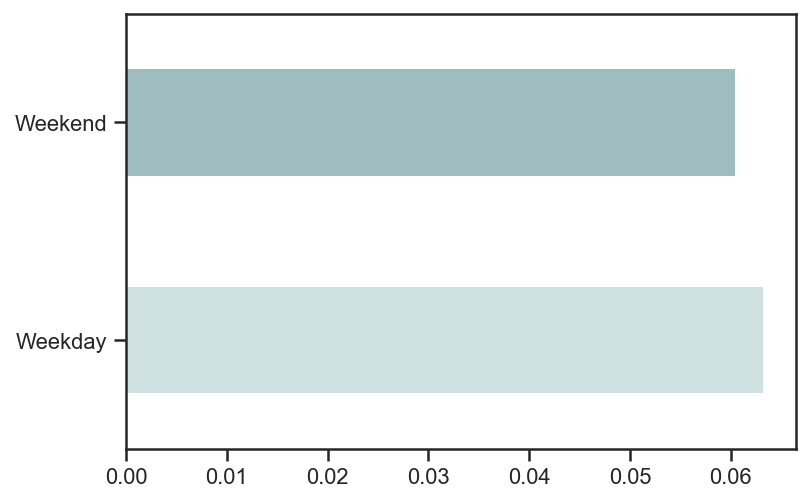

In [15]:
prop_has_learn = (pd.Series(has_word_learn.groupby('created_at')['has_learn']
                    .value_counts(normalize = True).values[[1, 3]],
                    index = ['Weekday', 'Weekend']))
sns.set(style = 'ticks', palette= 'bone_r')
prop_has_learn.plot(kind = 'barh')

### Fork Events


Let's turn to the fork repositories and see which organizations are mostly involved and during which days.

In [16]:
fork_events = (github_data_copy[github_data_copy['payload.forkee.created_at'].notnull()]
              [['payload.forkee.created_at', 'payload.forkee.size', 
                'payload.pull_request.head.repo.forks_count','org.login']]
              .reset_index(drop = True))
print(fork_events.shape)
fork_events.head()

(46782, 4)


,payload.forkee.created_at,payload.forkee.size,payload.pull_request.head.repo.forks_count,org.login
0,Sunday,67.0,NaN,aws
1,Sunday,568.0,NaN,mozilla
2,Sunday,304.0,NaN,None
3,Sunday,10.0,NaN,None
4,Sunday,7602.0,NaN,cyberark


It seems like `microsoft` is involved in the biggest fork repositories across all days except for Sunday. 

`learn-co-students` sounds like an educational program, which mostly explains why it has the highest number, but small size, of fork repositories.

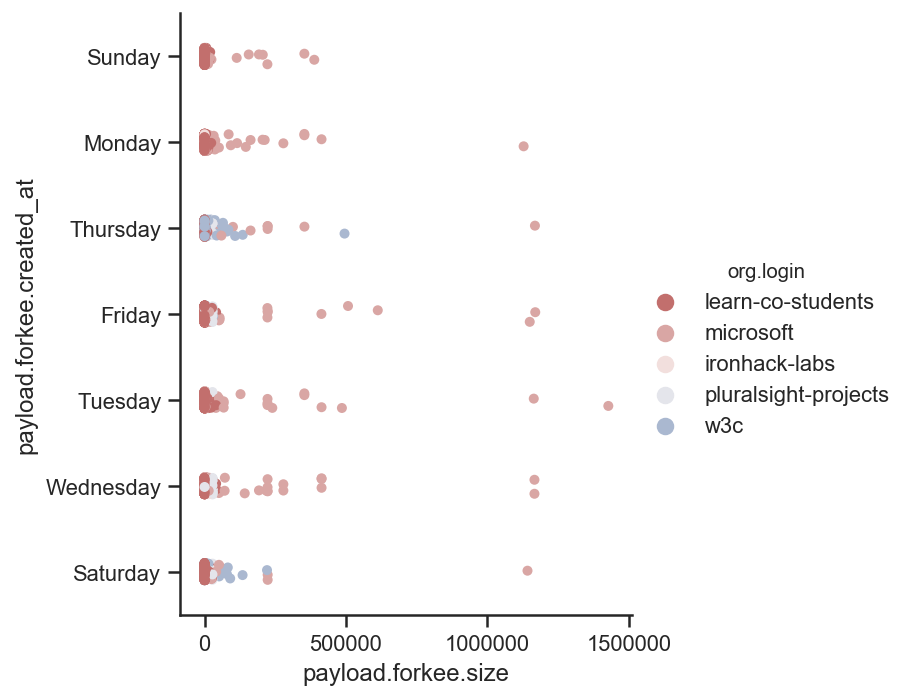

In [17]:
top_5_forked_orgs = fork_events['org.login'].value_counts(normalize = True)[:5].index
top_5_fork_events = fork_events[fork_events['org.login'].isin(top_5_forked_orgs)]

sns.set(style = 'ticks', palette= 'vlag_r')
sns.catplot(x = 'payload.forkee.size', y = 'payload.forkee.created_at', hue = 'org.login', data = top_5_fork_events)

### Pull Events


Lastly, let's get the pull events to see if there is anything interesting going on.

In [18]:
pull_events = (github_data_copy[github_data_copy['type'] == 'PullRequestEvent']
    [['repo.name', 'actor.login', 'org.login',
      'payload.pull_request.created_at', 'payload.pull_request.base.repo.language']]
    .reset_index(drop = True))

print(pull_events.shape)
pull_events.head()

(213442, 5)


,repo.name,actor.login,org.login,payload.pull_request.created_at,payload.pull_request.base.repo.language
0,fisker/power-cartesian-product,dependabot-preview[bot],None,Sunday,JavaScript
1,fisker/prettier-format,dependabot-preview[bot],None,Sunday,JavaScript
2,dhis2/app-runtime,dependabot-preview[bot],dhis2,Friday,TypeScript
3,ssube/salty-dog,renovate[bot],None,Sunday,TypeScript
4,fisker/fei.js,dependabot-preview[bot],None,Sunday,JavaScript


Of all the programming languages, let's focus on the top 5, and see how the number of uses varies between the usual users and bot users.

In [19]:
top_5_pull_languages = pull_events['payload.pull_request.base.repo.language'].value_counts()[:5].index

# examine only the top 5 programming languages for simplicity's sake 
top_5_pull_languages_df = (pull_events[pull_events['payload.pull_request.base.repo.language']
                                             .isin(top_5_pull_languages)])

# proportions of usage of the top 5 programming languages by usual users
usual = (top_5_pull_languages_df[~top_5_pull_languages_df['actor.login'].str.contains('bot')]
         ['payload.pull_request.base.repo.language']
         .value_counts(normalize = True)
         .to_frame()
         .rename(columns = {'payload.pull_request.base.repo.language': 'usual'}))

# proportions of usage of the top 5 programming languages by bot users
bots = (top_5_pull_languages_df[top_5_pull_languages_df['actor.login'].str.contains('bot')]
        ['payload.pull_request.base.repo.language']
        .value_counts(normalize = True)
        .to_frame()
        .rename(columns = {'payload.pull_request.base.repo.language': 'bots'}))

joined_distributions = pd.concat([usual, bots], axis = 1, sort = False).T
joined_distributions

,JavaScript,Python,Java,HTML,TypeScript
usual,0.397408,0.211553,0.153011,0.142327,0.095701
bots,0.257525,0.537056,0.026939,0.081934,0.096546


Just looking at the distributions of usual users and bot users, it appears that they are quite different. 

This can be a potential candidate for a permutation test: 
* do the usage of the top 5 programming languages by usual users and bots have a similar distribution?

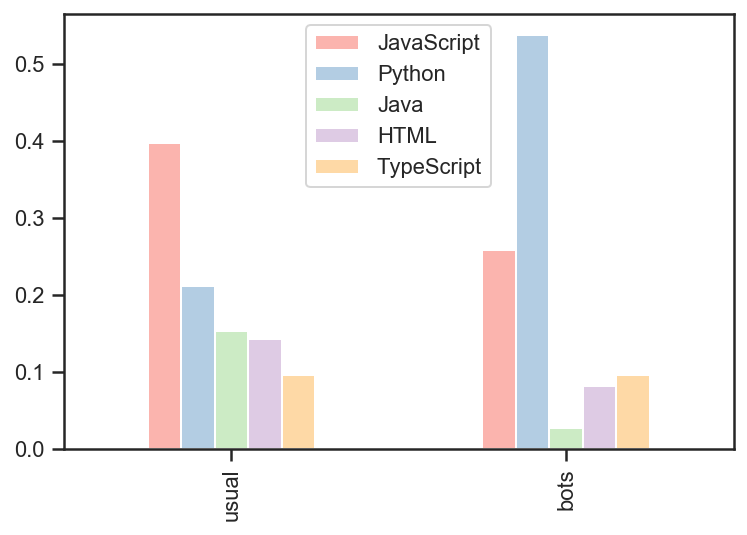

In [20]:
sns.set(style = 'ticks', palette= 'Pastel1')
joined_distributions.plot(kind = 'bar')

What about the usage of the top 5 programming languages between weekdays and weekend? Do they vary a lot also?

In [21]:
weekday_vs_weekend_languages = (top_5_pull_languages_df
 .replace({'payload.pull_request.created_at': 
           {**dict.fromkeys(['Monday','Tuesday','Wednesday','Thursday', 'Friday'], 'Weekday'), 
           **dict.fromkeys(['Saturday','Sunday'], 'Weekend')}})
 .pivot_table(index = 'payload.pull_request.base.repo.language', columns = 'payload.pull_request.created_at', 
             aggfunc = 'size')
 .apply(lambda x: x / x.sum())
).T
weekday_vs_weekend_languages

payload.pull_request.base.repo.language,HTML,Java,JavaScript,Python,TypeScript
payload.pull_request.created_at,,,,,
Weekday,0.110624,0.089587,0.318369,0.386738,0.094682
Weekend,0.142115,0.133013,0.436731,0.182051,0.106090


We can see that people use *Javascript* more on the weekend than on the weekdays, and use *Python* more on the weekdays than on the weekend. 

We will do a permutation test to find out exactly whether the two groups come from the same distribution.

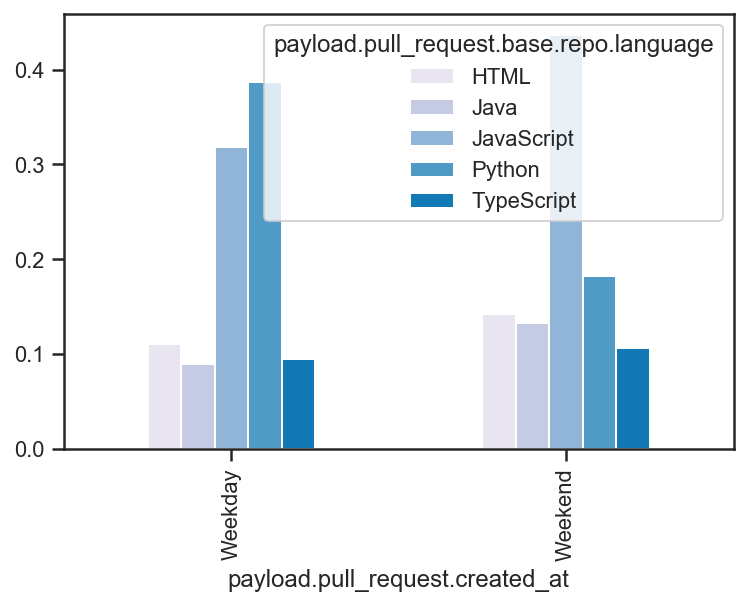

In [22]:
sns.set(style = 'ticks', palette= 'PuBu')
weekday_vs_weekend_languages.plot(kind = 'bar')

### Assessment of Missingness

Let's first have a look at which columns have null values.

In [23]:
github_data_copy.isnull().sum()

actor.login                                            0
created_at                                             0
org.login                                        1346569
payload.commits                                   997220
payload.forkee.created_at                        1927896
payload.forkee.size                              1927896
payload.pull_request.base.repo.language          1738315
payload.pull_request.created_at                  1716069
payload.pull_request.head.repo.forks_count       1716342
payload.pull_request.head.repo.has_issues        1716342
payload.pull_request.head.repo.has_pages         1716342
payload.pull_request.head.repo.license.key       1833701
payload.pull_request.head.repo.watchers_count    1716342
repo.name                                              0
type                                                   0
dtype: int64

### NMAR Column

**payload.pull_request.head.repo.license.key**

To add a license to the Github repository, you have to first:
1. Click on "Create new file" Button.
2. Type the file name as License.txt or License.md in the input box next to your repository name, a drop down button appears towards right side.
3. Choose the type of license of your choice.
4. Click "Commit new file"

Due to this involved process of getting a license key, some people may not bother with creating a license
though other contributors may benefit from it.
More information on the repositories' README.MD can provide more insight as to if the repositories need to
include the software licenses.

### MAR Dependence

#### Is the missingness of the organizations MAR dependent on the day of the week?

Since I am testing MAR dependence on a categorical column, I will use TVD as the test statistics for the permutation test. I'm going to set the significance level to be *0.01%*, since `github_data` has a very high number of rows, making the distribution of the simulations much narrower. 

Null hypothesis: the missingness of the organizations is *not* MAR dependent on the day of the week.

Alternative hypothesis: the missingness of the organizations *is* MAR dependent on the day of the week.

In [24]:
# test statistic for categorical columns
def tvd(distr):
    return distr.diff().abs().iloc[-1].sum() / 2

def permutation_test(df, col1, col2, N):
    tvds = []

    for _ in range(N):

        distr = (df[[col1, col2]]
              # shuffle the 'is_null' column 
             .assign(**{col1 + '_isnull': 
                        df[col1].isnull().sample(frac = 1).reset_index(drop = True)})                            
             .pivot_table(index = col1 + '_isnull', columns = col2, aggfunc = 'size')
             # computes a new TVD for every shuffling of the label column 
             .apply(lambda x: x / x.sum(), axis = 1))

        tvds.append(tvd(distr))

    tvds = pd.Series(tvds)
    
    return tvds

def get_pval(tvds, obs_tvd):
    return (tvds >= obs_tvd).mean()

It looks like the distributions are not very similar. Let's run a permutation test to check.

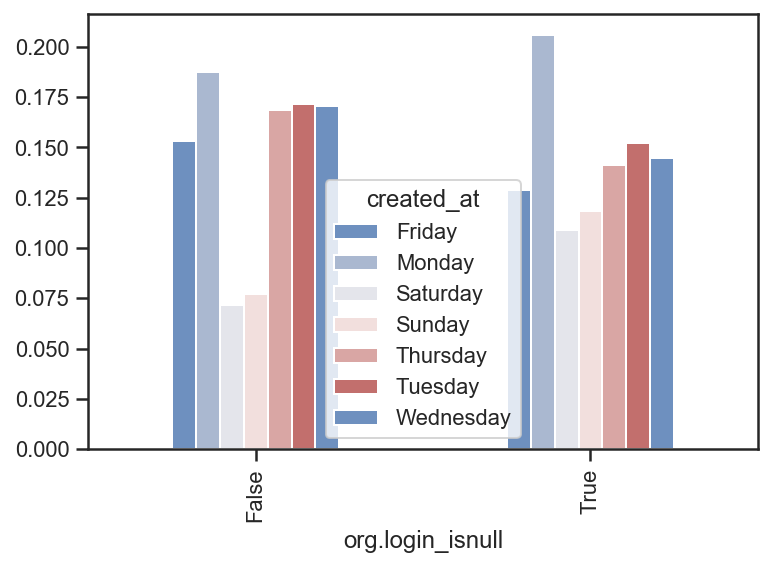

In [25]:
day_of_week_org_nulls = (commits_info
         .assign(**{'org.login_isnull': commits_info['org.login'].isnull()})                            
         .pivot_table(index = 'org.login_isnull', columns = 'created_at', aggfunc = 'size')
         .apply(lambda x: x / x.sum(), axis = 1))

sns.set(style = 'ticks', palette= 'vlag')
day_of_week_org_nulls.plot(kind = 'bar')

In [26]:
obs_tvd = tvd(day_of_week_org_nulls)
tvds = permutation_test(commits_info, 'org.login', 'created_at', 100)
pval = get_pval(tvds, obs_tvd)
pval

0.0

The observed TVD is very far off to the right of the distribution. A part of the reason may be that there is much less variance in a dataframe as big as this.

Nevertheless, since the pval is significantly below 0.0001, we reject the null hypothesis and that the missingness of the organizations is MAR dependent on the day of the week.

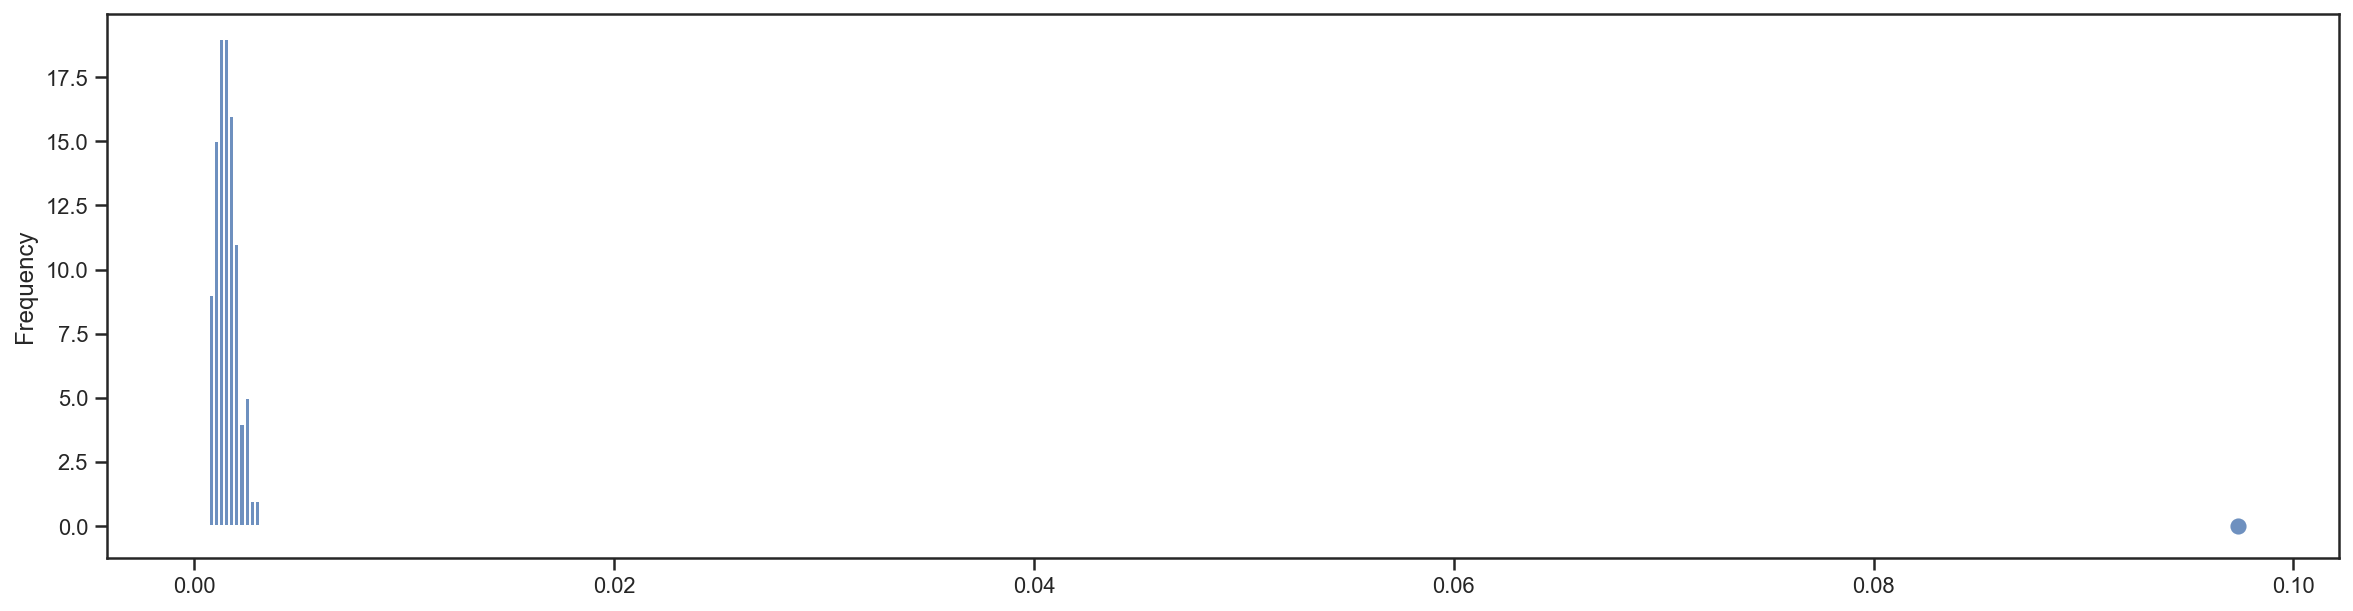

In [27]:
fig, ax = plt.subplots(figsize=[20,5])
tvds.plot(kind = 'hist', ax = ax)
plt.scatter(obs_tvd, 0, marker='o', s=50)

#### Is the missingness of the organizations MAR dependent on the top 5 pull requests' programming languages?

Since I am testing MAR dependence on a categorical column, I will use TVD as the test statistics for the permutation test. I'm going to set the significance level to be *0.01%*, since `github_data` has a very high number of rows, making the distribution of the simulations much narrower. 

Null hypothesis: the missingness of the organizations is *not* MAR dependent on the top 5 pull requests' programming languages.

Alternative hypothesis: the missingness of the organizations *is* MAR dependent on the top 5 pull requests' programming languages.

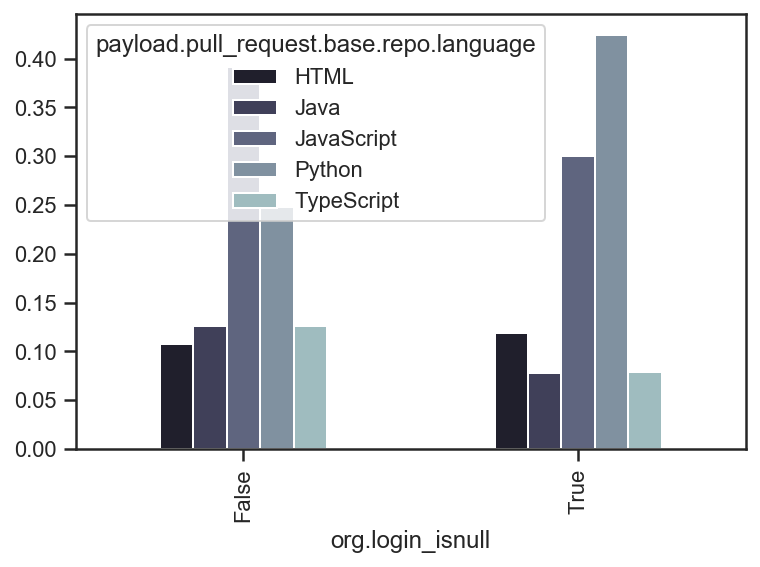

In [28]:
language_org_nulls = (top_5_pull_languages_df
     .assign(**{'org.login_isnull': top_5_pull_languages_df['org.login'].isnull()})                            
     .pivot_table(index = 'org.login_isnull', columns = 'payload.pull_request.base.repo.language', 
                  aggfunc = 'size', fill_value = 0)                
     .apply(lambda x: x / x.sum(), axis = 1))

sns.set(style = 'ticks', palette= 'bone')
language_org_nulls.plot(kind = 'bar')

In [29]:
obs_tvd = language_org_nulls.diff().iloc[-1].abs().sum() / 2
tvds = permutation_test(top_5_pull_languages_df, 'org.login', 'payload.pull_request.base.repo.language', 100)
pval = (tvds >= obs_tvd).mean()
pval

0.0

The pval is significantly below 0.0001, we reject the null hypothesis and that the missingness of the organizations is MAR dependent on the top 5 pull requests' programming languages.

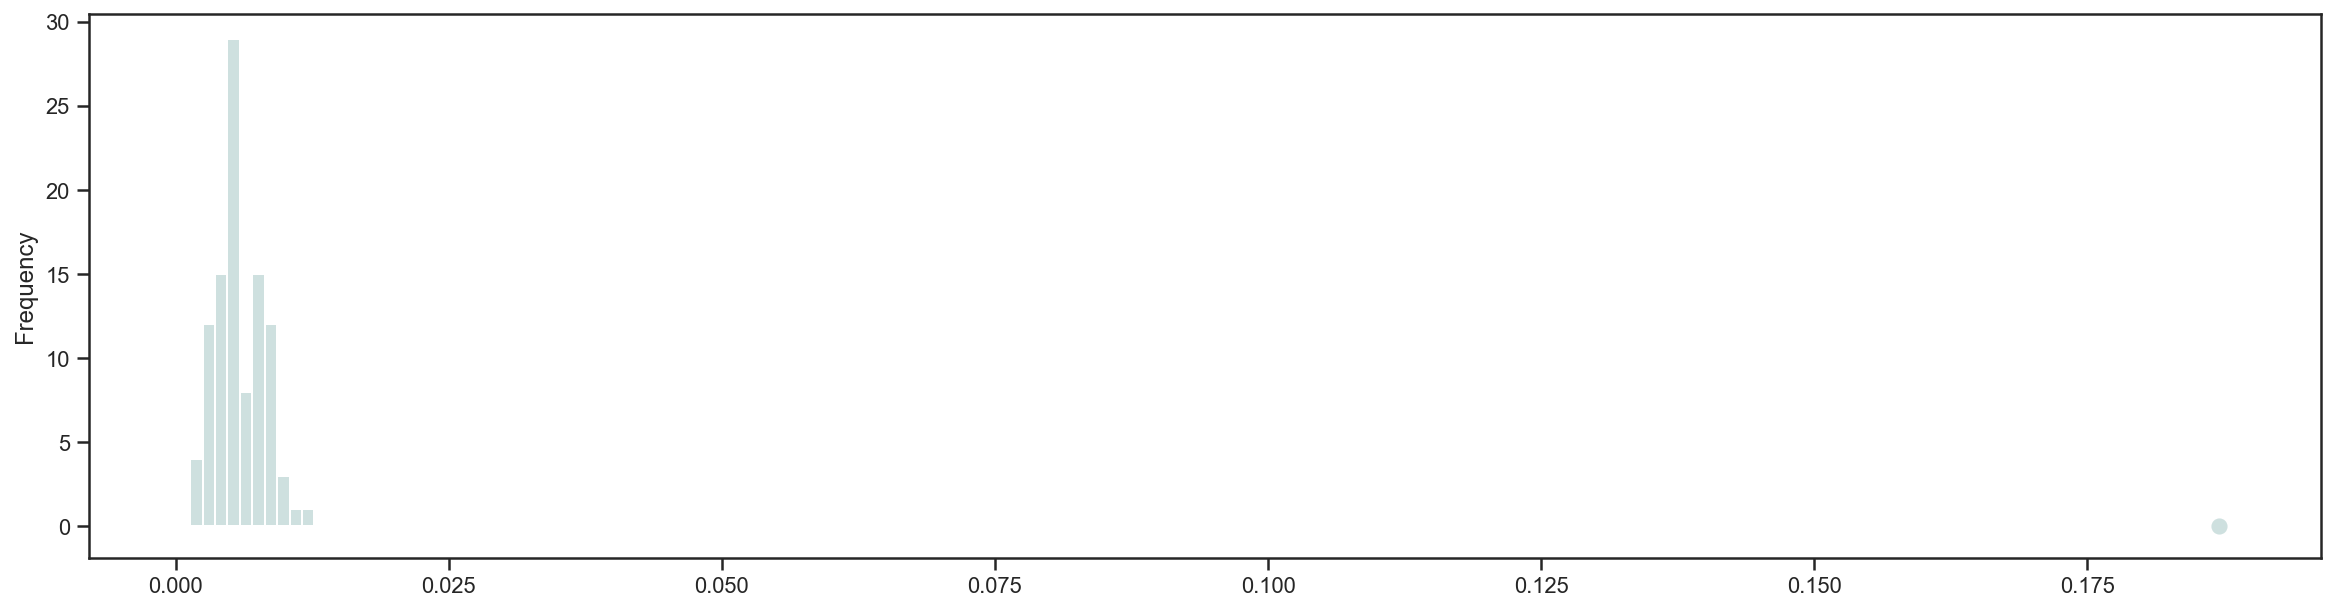

In [30]:
sns.set(style = 'ticks', palette= 'bone_r')
fig, ax = plt.subplots(figsize=[20,5])
tvds.plot(kind = 'hist', ax = ax)
plt.scatter(obs_tvd, 0, marker='o', s=50)

#### Is the missingness of organizations MAR dependent on whether the pulled repos have pages?

Null hypothesis: the missingness of the organizations is *not* MAR dependent on whether the pulled repos have pages.

Alternative hypothesis: the missingness of the organizations *is* MAR dependent on whether the pulled repos have pages.

For this particular permutation test, I will sample from `github_data_copy` 100,000 and 50,000 rows respectively to demonstrate the effect of the sample size on the p-value. Here, the significance level will be set to 5% because I'm  just taking a sample of the dataset, so the variance will be higher, resulting in a higher chance under which the distribution is as extreme as the observed TVD.

#### Sampling 100,000 rows from github_data_copy

In [31]:
github_sample = github_data_copy.sample(100000).reset_index(drop = True)

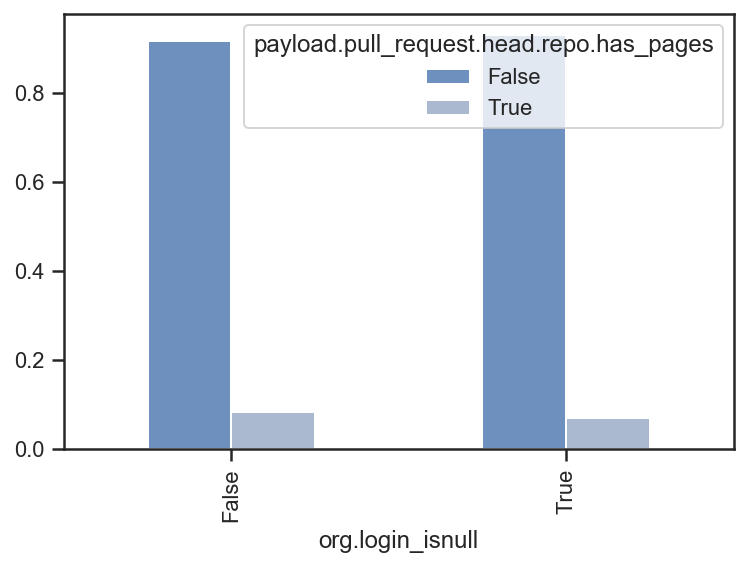

In [32]:
pages_org_nulls = (github_data_copy
     .assign(**{'org.login_isnull': github_data_copy['org.login'].isnull()})                            
     .pivot_table(index = 'org.login_isnull', columns = 'payload.pull_request.head.repo.has_pages', 
                  aggfunc = 'size', fill_value = 0)                
     .apply(lambda x: x / x.sum(), axis = 1))

sns.set(style = 'ticks', palette= 'vlag')
pages_org_nulls.plot(kind = 'bar')

In [33]:
obs_tvd = tvd(pages_org_nulls)
tvds = permutation_test(github_sample, 'org.login', 'created_at', 1000)
pval = get_pval(tvds, obs_tvd)
pval

0.002

With 100,000 rows, the p-value of 0 rejects the null hypothesis and that the missingness of organizations *is* MAR dependent on whether the pulled repos have pages. 

However, let's cut down the sample size to 50,000 this time, and see what happens to the p-value.

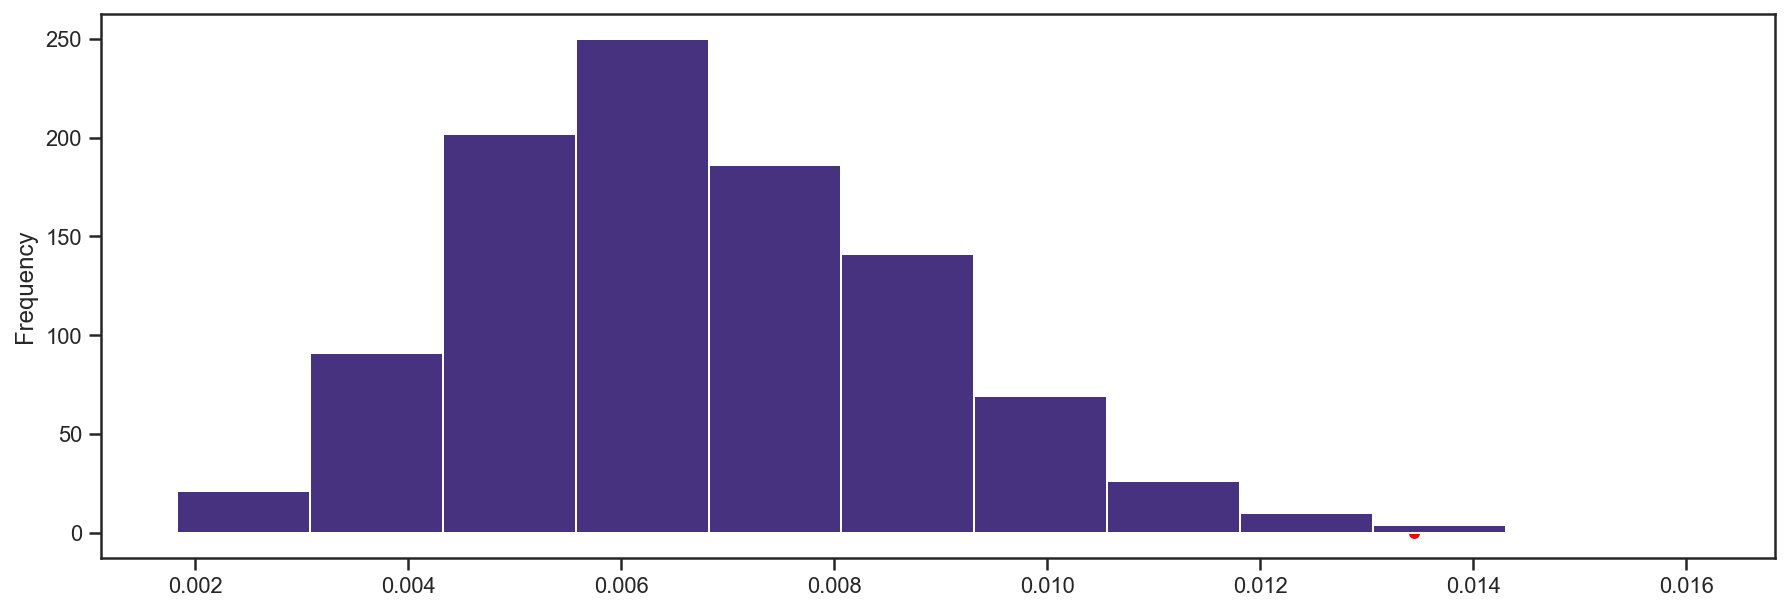

In [34]:
sns.set(style = 'ticks', palette= 'viridis')
fig, ax = plt.subplots(figsize=[15,5])
plt.scatter(obs_tvd, 0, marker='o', color = 'red', s=20)
tvds.plot(kind = 'hist', ax = ax)

#### Sampling 50,000 rows from github_data_copy

In [35]:
github_sample = github_data_copy.sample(50000).reset_index(drop = True)

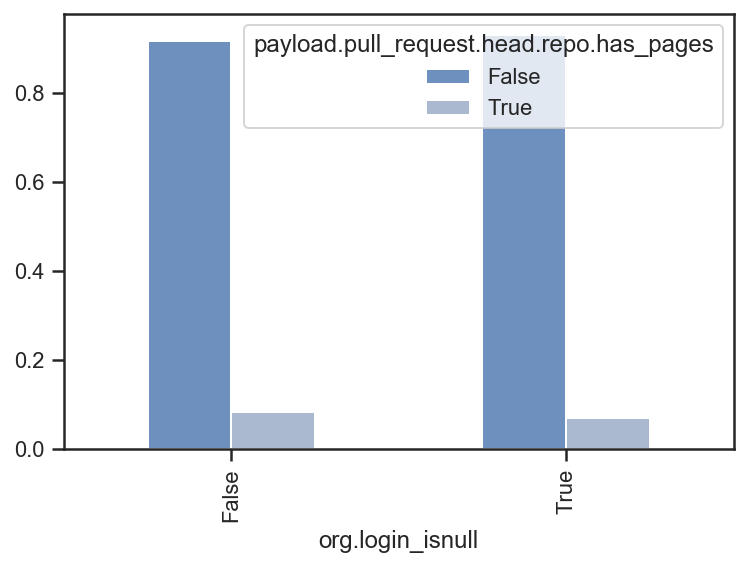

In [36]:
pages_org_nulls = (github_data_copy
     .assign(**{'org.login_isnull': github_data_copy['org.login'].isnull()})                            
     .pivot_table(index = 'org.login_isnull', columns = 'payload.pull_request.head.repo.has_pages', 
                  aggfunc = 'size', fill_value = 0)                
     .apply(lambda x: x / x.sum(), axis = 1))

sns.set(style = 'ticks', palette= 'vlag')
pages_org_nulls.plot(kind = 'bar')

In [37]:
obs_tvd = tvd(pages_org_nulls)
tvds = permutation_test(github_sample, 'org.login', 'created_at', 1000)
pval = get_pval(tvds, obs_tvd)
pval

0.078

Interestingly, the p-value this time is *above* the significance level of 0.05, making us to fail to reject the null hypothesis and that the missingness of organizations is *not* MAR dependent on whether the pulled repos have pages.

Looking carefully at the spread of the distribution, we see that the right tail extends to almost 0.02, whereas in the previous distribution it extends to less than 0.013. The reason being that when there is a smaller sample size, there is a higher chance the shuffled measurements change drastically, resulting in a higher TVD and eventually more spread in the distribution. 

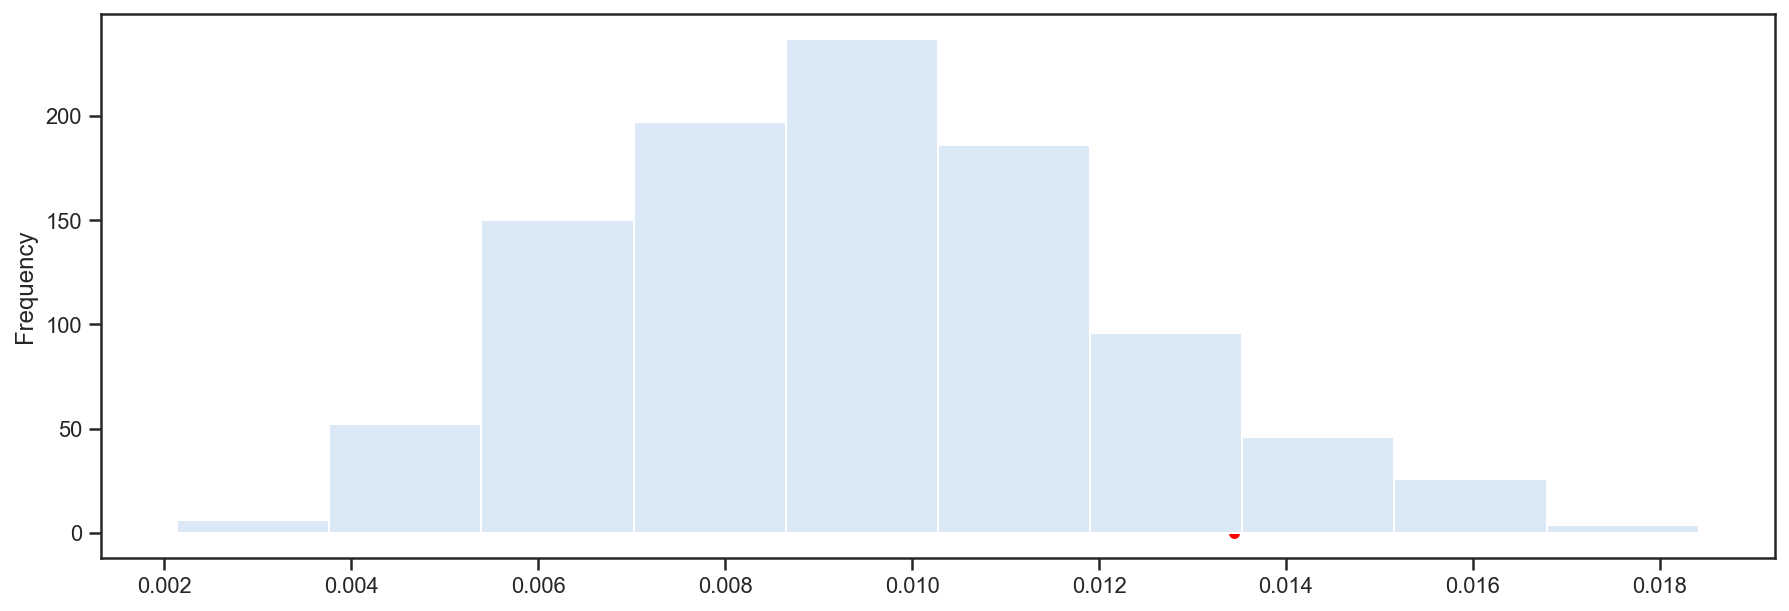

In [38]:
sns.set(style = 'ticks', palette= 'Blues')
fig, ax = plt.subplots(figsize=[15,5])
plt.scatter(obs_tvd, 0, marker='o', color = 'red', s=20)
tvds.plot(kind = 'hist', ax = ax)

#### Is the missingness of organizations MAR dependent on the pulled repos' watchers count?

Since the I am testing MAR dependence on a quantitative column, I'll use KS as the test statistics. I'll set the significance level to 5% since I am taking just a small subset of the whole dataset.

Just like the previous example, we'll sample from `github_data_copy` 1000 and 500 rows respectively to see how the p-value changes. 

#### Sampling 1,000 rows from github_data_copy

In [39]:
github_sample = github_data_copy.sample(1000).reset_index(drop = True)

0.13951879541410028

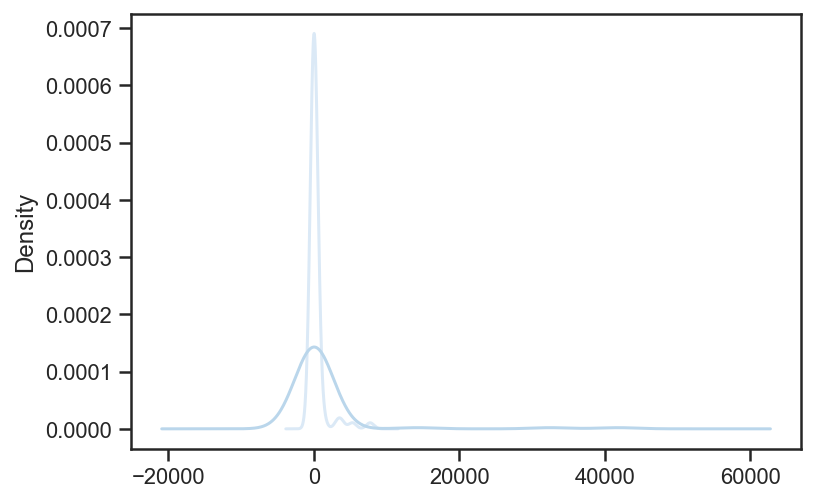

In [40]:
org_is_null = (
    github_sample.assign(org_isnull = github_sample['org.login'].isnull())
    [['org_isnull', 'payload.pull_request.head.repo.watchers_count']])
gpTrue = org_is_null.groupby('org_isnull').get_group(True)['payload.pull_request.head.repo.watchers_count']
gpFalse = org_is_null.groupby('org_isnull').get_group(False)['payload.pull_request.head.repo.watchers_count']

org_is_null.groupby('org_isnull')['payload.pull_request.head.repo.watchers_count'].plot(kind = 'kde')    
obs = ks_2samp(gpTrue, gpFalse).statistic
obs

With 1000 rows, we see that the p-value is below the significance level, and so we reject the null hypothesis and that the missingness of organizations *is* MAR dependent on the pulled repos' watchers count. 

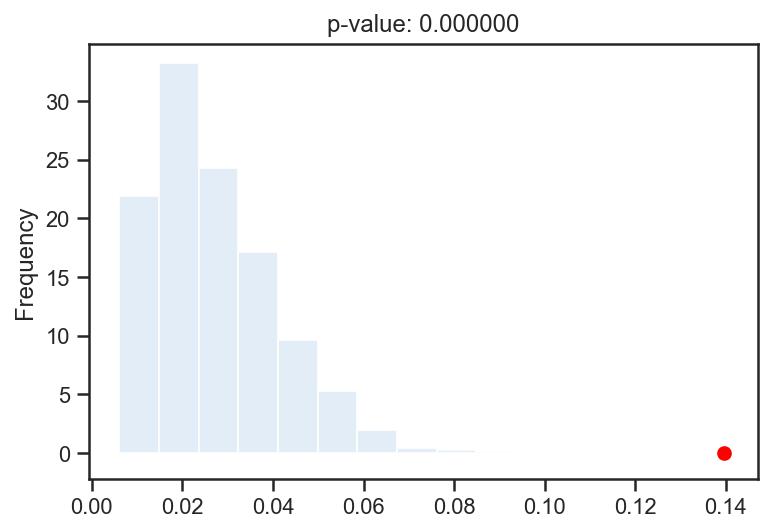

In [41]:
N = 1000

ks_list = []
for _ in range(N):
    
    distr = (github_sample[['org.login', 'payload.pull_request.head.repo.watchers_count']]
             .assign(org_isnull = github_sample['org.login'].isnull().sample(frac = 1).reset_index(drop = True)))
    
    
    # compute the KS
    grps = distr.groupby('org_isnull')['payload.pull_request.head.repo.watchers_count']
    ks = ks_2samp(grps.get_group(True), grps.get_group(False)).statistic
    
    ks_list.append(ks)
    
ks_list = pd.Series(ks_list)

pval = (ks_list >= obs).mean()

pd.Series(ks_list).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % pval)
sns.set(style = 'ticks', palette= 'tab20c')
plt.scatter(obs, 0, color='red', s=40);

#### Sampling 400 rows from github_data_copy

In [61]:
github_sample = github_data_copy.sample(400).reset_index(drop = True)

0.04700854700854702

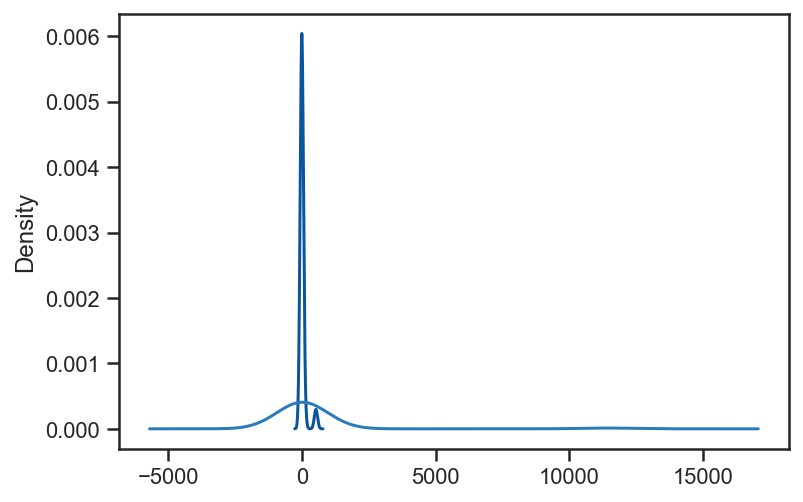

In [62]:
org_is_null = (
    github_sample.assign(org_isnull = github_sample['org.login'].isnull())
    [['org_isnull', 'payload.pull_request.head.repo.watchers_count']])
gpTrue = org_is_null.groupby('org_isnull').get_group(True)['payload.pull_request.head.repo.watchers_count']
gpFalse = org_is_null.groupby('org_isnull').get_group(False)['payload.pull_request.head.repo.watchers_count']

sns.set(style = 'ticks', palette= 'Blues_r')
org_is_null.groupby('org_isnull')['payload.pull_request.head.repo.watchers_count'].plot(kind = 'kde')    
obs = ks_2samp(gpTrue, gpFalse).statistic
obs

With only 400 rows, the p-value this time is *above* the significance level. Hence, we fail to reject the null hypothesis and that the missingness of organizations is *not* MAR dependent on the pulled repos' watchers count. 

Unlike the previous permutation test, this time I used much smaller sample sizes since the KS measures the exact distance between the 2 distributions, making the distribution of test statistics much less likely to have a wider spread and thus a lower p-value. As a result, I have to use a very small sample in order to allow for this wider spread and hence a higher p-value.  

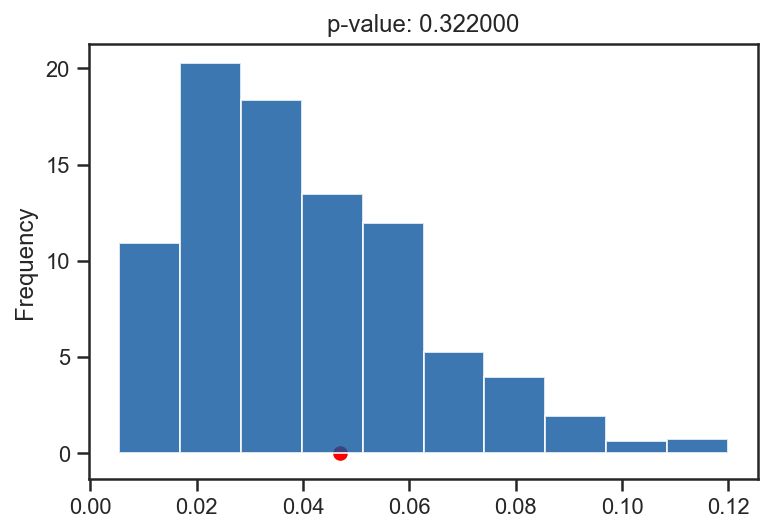

In [63]:
N = 1000

ks_list = []
for _ in range(N):
    
    distr = (github_sample[['org.login', 'payload.pull_request.head.repo.watchers_count']]
             .assign(org_isnull = github_sample['org.login'].isnull().sample(frac = 1).reset_index(drop = True)))
    
    
    # compute the KS
    grps = distr.groupby('org_isnull')['payload.pull_request.head.repo.watchers_count']
    ks = ks_2samp(grps.get_group(True), grps.get_group(False)).statistic
    
    ks_list.append(ks)
    
ks_list = pd.Series(ks_list)

pval = (ks_list >= obs).mean()

pd.Series(ks_list).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % pval)

plt.scatter(obs, 0, color='red', s=40);

### Hypothesis Test / Permutation Test

During the EDA, I discovered some interesting phenemena in the pull events, in particular in the usage of the top 5 programming languages under different circumstances. One of which, is the usage between usual users and bot users.

#### 1. Do the usage of the top 5 programming languages vary between usual users and bot users?

* Null Hypothesis: Usage of the top 5 programming languages by usual users and bots have a similar distribution.
* Alternative Hypothesis: Usage of the top 5 programming languages by usual users and bots have different distributions.
* Significance Level: 0.01% because I'm using a a much larger dataset than I used for the previous 2 permutation tests.

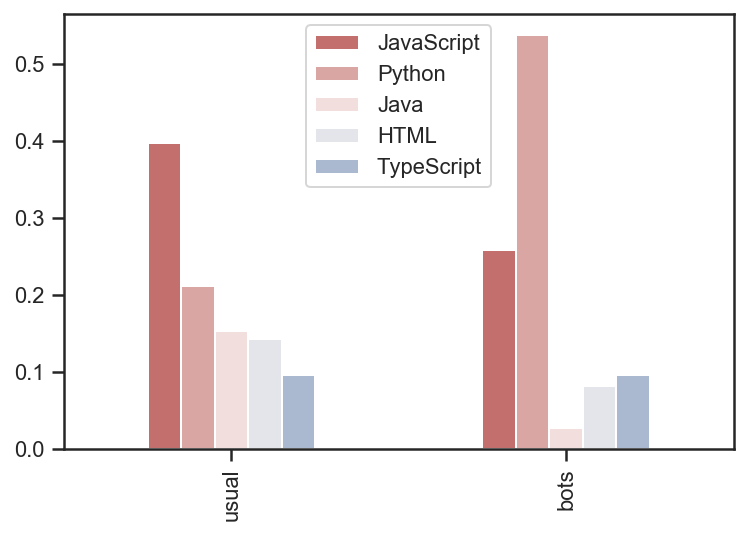

In [45]:
sns.set(style = 'ticks', palette= 'vlag_r')
joined_distributions.plot(kind = 'bar')

In [46]:
obs_tvd = tvd(joined_distributions)

N = 100
tvds = []
for _ in range(N):
    distr = (top_5_pull_languages_df[['actor.login', 'payload.pull_request.base.repo.language']]
             .assign(**{'Shuffled Language': top_5_pull_languages_df['payload.pull_request.base.repo.language']
                       .sample(frac = 1).reset_index(drop = True)}))
    # gets the proportions of usage of top 5 programming languages by usual users
    usual = (distr[~distr['actor.login'].str.contains('bot')]
             ['Shuffled Language']
             .value_counts(normalize = True)
             .to_frame()
             .rename(columns = {'Shuffled Language': 'usual'}))
    # gets the proportions of usage of top 5 programming languages by bot users
    bots = (distr[distr['actor.login'].str.contains('bot')]
            ['Shuffled Language']
            .value_counts(normalize = True)
            .to_frame()
            .rename(columns = {'Shuffled Language': 'bots'}))

    joined_distr = pd.concat([usual, bots], axis = 1, sort = False).T
    tvds.append(tvd(joined_distr))

tvds = pd.Series(tvds)
pval = get_pval(tvds, obs_tvd)
pval

0.0

Since the pval is significantly below the significance level, we reject the null hypothesis in favor of the alternative hypothesis. However, keep in mind that `top_5_pull_languages_df` has 126,000 rows, which may affect the p-value. If we sample just a subset of the dataset, we may see a different outcome just like the previous 2 permutation tests.

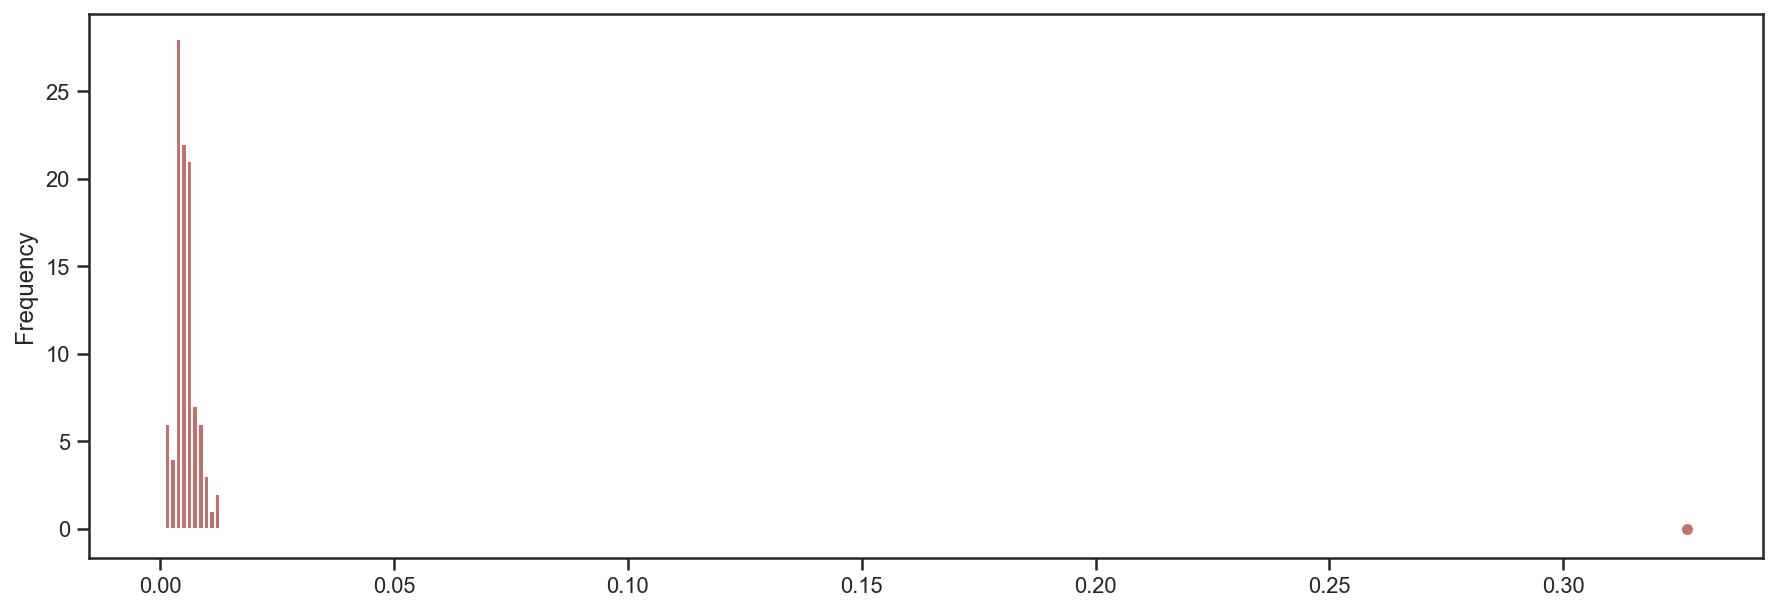

In [47]:
fig, ax = plt.subplots(figsize=[15,5])
tvds.plot(kind = 'hist', ax = ax)
plt.scatter(obs_tvd, 0, marker='o', s=20)

#### 2. Do people use different programming languages on weekdays and weekends?

* Null Hypothesis: Usage of the top 5 programming languages on the weekdays and on the weekend have a similar distribution.
* Alternative Hypothesis: Usage of the top 5 programming languages on the weekdays and on the weekend have different distributions.
* Significance Level: 0.01% because I'm using a a much larger dataset than I used for the previous 2 permutation tests.

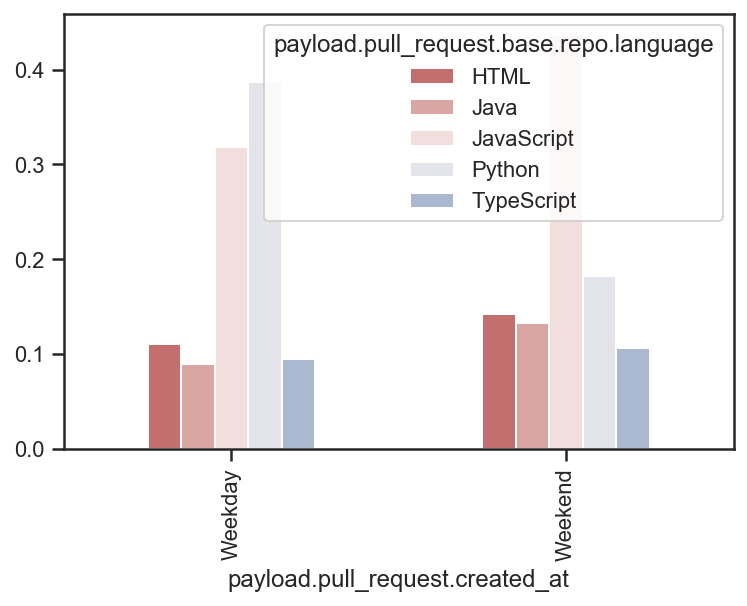

In [48]:
sns.set(style = 'ticks', palette= 'vlag_r')
weekday_vs_weekend_languages.plot(kind = 'bar')

In [49]:
weekday_vs_weekend_languages.diff().abs().iloc[-1].sum() / 2

0.20468680372391038

In [50]:
obs_tvd = tvd(weekday_vs_weekend_languages)

N = 100
tvds = []
weekday_vs_weekend = (top_5_pull_languages_df
     .replace({'payload.pull_request.created_at': 
               {**dict.fromkeys(['Monday','Tuesday','Wednesday','Thursday', 'Friday'], 'Weekday'), 
               **dict.fromkeys(['Saturday','Sunday'], 'Weekend')}}))

for _ in range(N):
    
    sim_weekday_vs_weekend_languages = (weekday_vs_weekend
     .assign(**{'Shuffled Time': weekday_vs_weekend['payload.pull_request.created_at']
                .sample(frac = 1).reset_index(drop = True)})
     .pivot_table(index = 'Shuffled Time', columns = 'payload.pull_request.base.repo.language', 
                 aggfunc = 'size')
     .apply(lambda x: x / x.sum()))
    
    tvds.append(tvd(sim_weekday_vs_weekend_languages))
    
tvds = pd.Series(tvds)
pval = (tvds <= obs_tvd).mean()
pval

0.0

Since the pval is significantly below the significance level, we reject the null hypothesis in favor of the alternative hypothesis, and that people use top 5 programming languages differently on weekdays and weekend.

There is something interesting to note here. I am using `top_5_pull_languages_df` as well for this permutation test, yet the p-value is much more significant. One reason could be explained by the fact that the distribution of test statistics expects a larger TVD, but the observed TVD did not show that. In addition, as opposed to the observed TVD being on the end of the righ tail, we see that the observed TVD is actually to the *left* of the distribution.

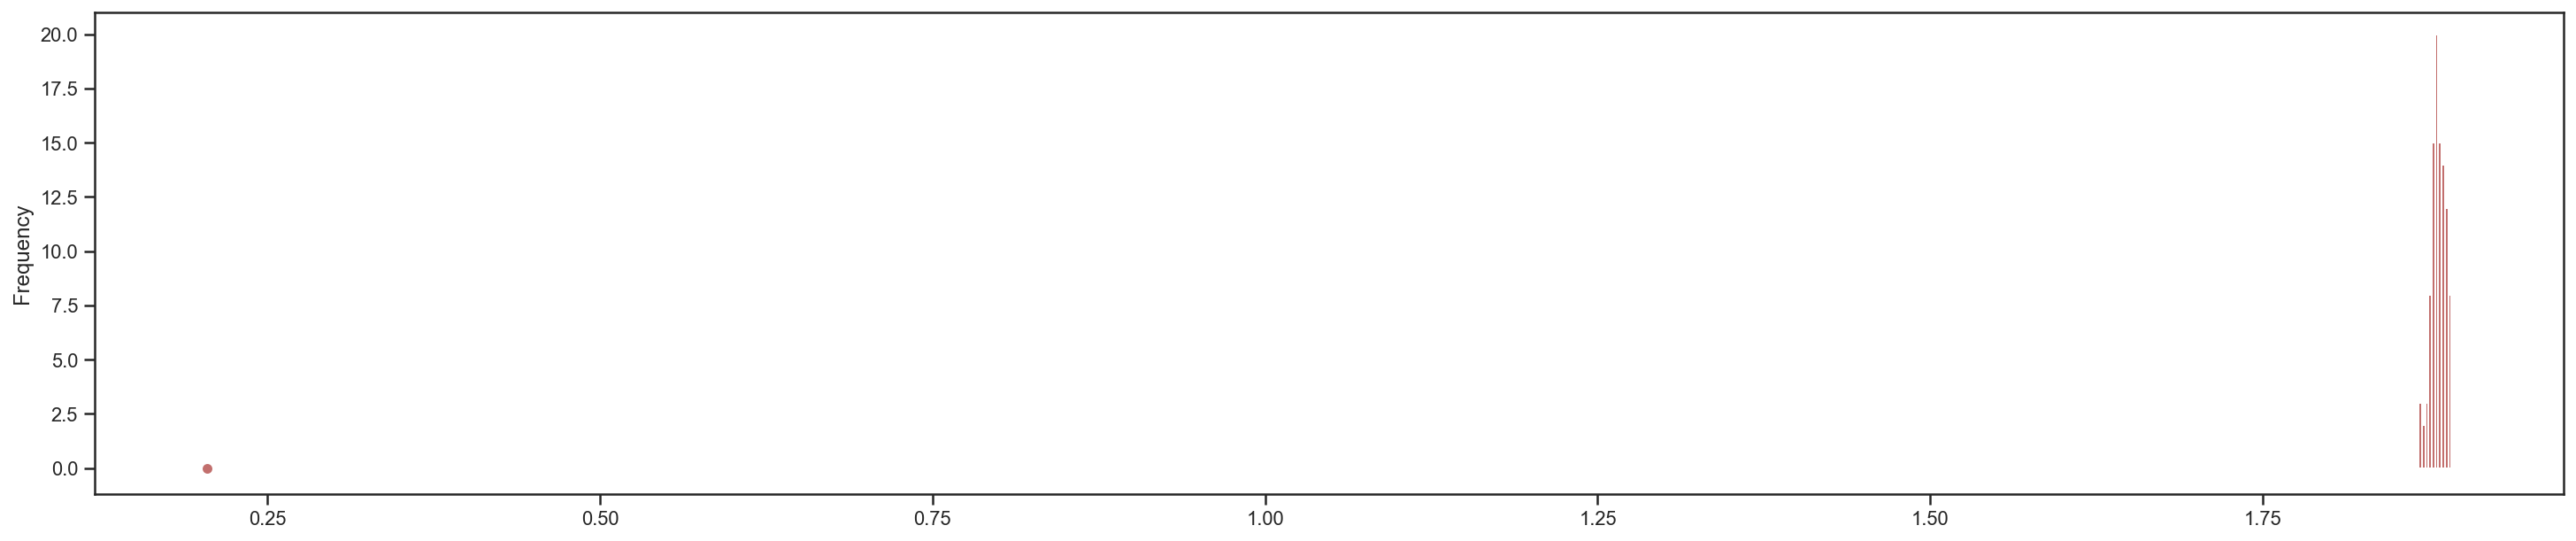

In [51]:
fig, ax = plt.subplots(figsize=[25,5])
tvds.plot(kind = 'hist', ax = ax)
plt.scatter(obs_tvd, 0, marker='o', s=20)